In [1]:
!pip install prophet

  Using cached prophet-1.1.5-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.0-py3-none-any.whl.metadata (1.3 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 87.5 kB/s eta 0:02:32
   ---------------------------------------- 0.0/13.3 MB 87.5 kB/s eta 0:02:32
   ------

In [3]:
import pandas as pd
import numpy as np

# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import prophet.plot

# Plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

First, we load in the hourly data created in the wrangling step.

In [6]:
df = pd.read_csv(r"C:\Users\Administrator\Desktop\Project\cleaned-daily_10.csv", parse_dates=['Date'], index_col=['Date'])
df

kWh
Date                 
2017-01-01  393707.05
2017-01-02  538022.63
2017-01-03  549714.09
2017-01-04  548953.12
2017-01-05  545259.28
...               ...
2019-12-28  462485.64
2019-12-29  442889.22
2019-12-30  519266.06
2019-12-31  520889.60
2020-01-01  462607.10

[1096 rows x 1 columns]

Next, we rename the columns for use in the models below. The models below expect the data to have a `ds` column (representing the timestamps) and a `y` column (representing the values of the time series).

In [8]:
df.index.names = ['ds']
df.rename(columns={'kWh':'y'}, inplace=True)

We divide the data into three sets: train, validation, and test sets. The test set starts from the timestamp 2019-12-01. In the remaing portion of the data, the first 80% of it is used for training, and the remaining 20% is used for validation. However, we may choose not to generate the validation set if it's not necessary.

In [10]:
def train_val_test_split(df, validation=True):
    train_end = '2019-12-01'

    train_val = df.loc[:train_end, :]
    test_df = df.loc[train_end:, :]

    # Let the ds indexing column be its own column as is required by the models below.
    for df in [train_val, test_df]:
        df.reset_index(inplace=True)
        
    if not validation:
        return train_val, test_df

    n = len(train_val)
    cutoff = int(n*0.8)

    train_df = train_val[:cutoff]
    val_df = train_val[cutoff:]
    return train_df, val_df, test_df

In [12]:
train_df, val_df, test_df = train_val_test_split(df)

## Prophet

### Description

Prophet is a open-source project from Facebook that aims to model time series data and make reliable forecasts. Essentially, a Prophet model is an additive model with several components: a seasonal component with multiple levels (e.g., yearly, weekly, daily, and user-defined seasonalities), a trend component which can be highly non-linear, and holiday effects. Prophet fits models with Stan, a probabilistic programming framework. Prophet estimates the parameters with maximum a posteriori estimates by default.


The model can typically be expressed with the following formula:

$$
\begin{aligned}
y_t=g(t)+s(t)+h(t)
\end{aligned}
$$

where:

* $y_t$ is the time series

* $g(t)$ is a (possibly smooth and nonlinear) function of the trend

* $s(t)$ represents the seasonal, periodic changes (e.g., yearly and weekly seasonalities)

* $h(t)$ models the effects of holidays, whose schedule may be irregular.

For more information, please see the article ([Taylor et al., 2018](https://peerj.com/preprints/3190/)).

### Some functions

In this subsection, we define several functions to help with modeling with Prophet.

In [15]:
def to_exp(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.exp)
    return res


def to_log(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.log)
    return res


def plot(forecast, train, x1,x2):
    """
    Plots two time series 'forecast' and 'train' in one plot mainly to compare them.
    Also plots the first time series against the second time series to determine 
    how similar they are. x1 is the starting time point and x2 is the ending time point.
    """
    yhat = forecast.set_index('ds').loc[x1:x2, 'yhat']
    y = train.set_index('ds').loc[x1:x2, 'y']
    plt.figure(figsize=(15,7))
    plt.plot(yhat, 'o-', label='Estimated')
    plt.plot(y, 'o', label='True')
    lower = forecast.set_index('ds').loc[x1:x2, 'yhat_lower']
    upper = forecast.set_index('ds').loc[x1:x2, 'yhat_upper']
    plt.fill_between(yhat.index, lower, upper, alpha=0.2)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.scatter(x=y, y=yhat)
    min_x = int(np.floor(np.min([yhat.min(), y.min()]))) 
    max_x = int(np.ceil(np.max([yhat.max(), y.max()])))
    r = range(min_x,max_x)
    plt.plot(r, r, 'r', label='y=x')
    plt.title('True (x-axis) against estimated (y-axis)')
    plt.legend()
    plt.show()
    

def acf_res(forecast, train):
    """
    Plots a autocorrelation plot of the residuals (y-true minus y-predicted) for training data.
    """
    date_range = train['ds']
    res = train.set_index('ds')['y'] - forecast.set_index('ds').loc[date_range, 'yhat']
    plot_acf(res)

    
def is_spring(ds):
    return ds.month in [3,4,5]

    
def is_summer(ds):
    """
    Determines whethere a timestamp ds is in the summer or not.
    """
    return ds.month in [6,7,8]


def is_winter(ds):
    """
    Determines whether a timestamp ds is in the winter.
    """
    return ds.month in [12,1,2]


def is_autumn(ds):
    return ds.month in [9,10,11]
    
    
def is_weekend(ds):
    """
    Determines whether a timestamp ds is in the weekend.
    """
    return ds.day_name() in ['Saturday', 'Sunday']


def is_weekday(ds):
    """
    Determines whether a timestamp ds is a weekday.
    """
    return not is_weekend(ds)


def is_winter_weekday(ds):
    """
    Determines whether a timestamp ds is a winter weekday.
    """
    return is_winter(ds) and is_weekday(ds)


def is_winter_weekend(ds):
    """
    Determines whether a timestamp ds is a winter weekend.
    """
    return is_winter(ds) and is_weekend(ds)


def is_summer_weekday(ds):
    """
    Determines whether a timestamp ds is a summer weekday.
    """
    return is_summer(ds) and is_weekday(ds)


def is_summer_weekend(ds):
    """
    Determines whether a timestamp ds is a summer weekend.
    """
    return is_summer(ds) and is_weekend(ds)


def is_first_half(ds):
    """
    Determines whether a timestamp is in the first half of a year (spring-summer)
    """
    return (ds.month >= 2 and ds.month <= 7)


def is_second_half(ds):
    """
    Determines whether a timestamp is in the second half of a year (autumn-summer)
    """
    return not is_first_half(ds)


def is_spring_weekday(ds):
    return is_spring(ds) and is_weekday(ds)


def is_spring_weekend(ds):
    return is_spring(ds) and is_weekend(ds)


def is_autumn_weekday(ds):
    return is_autumn(ds) and is_weekday(ds)


def is_autumn_weekend(ds):
    return is_autumn(ds) and is_weekend(ds)


def add_custom_seasonality(df):
    """
    Augments the dataframe df with several columns determining
    whether the corresponding datapoints belong to different seasoonalities. 
    """
    df = df.assign(
                       spring_weekday = df['ds'].apply(is_spring_weekday),
                       spring_weekend = df['ds'].apply(is_spring_weekend),
                       summer_weekday = df['ds'].apply(is_summer_weekday),
                       summer_weekend = df['ds'].apply(is_summer_weekend),
                       autumn_weekday = df['ds'].apply(is_autumn_weekday),
                       autumn_weekend = df['ds'].apply(is_autumn_weekend),
                       winter_weekday = df['ds'].apply(is_winter_weekday),
                       winter_weekend = df['ds'].apply(is_winter_weekend),
                       summer = df['ds'].apply(is_summer),
                       winter = df['ds'].apply(is_winter),
                       weekend = df['ds'].apply(is_weekend),
                       weekday = df['ds'].apply(is_weekday)
                  )
    return df


def mape(y_true, y_pred):
    """
    calculates the mean absolute percentage error, for use below
    """
    return mean_absolute_percentage_error(y_true, y_pred)

## Modeling

### Default Prophet model

First, we try the default Prophet model, that is, we do not specify any further options and use the default arguments for its `fit` method. In a default Prophet model for hourly time series, there is a yearly seasonality, weekly seasonality, and daily seasonality, The growth is linear and the components are additive.

In [16]:
model_default = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
model_default.fit(train_df)

10:23:15 - cmdstanpy - INFO - Chain [1] start processing
10:23:16 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = model_default.make_future_dataframe(periods=len(val_df), freq='H')
forecast = model_default.predict(future)

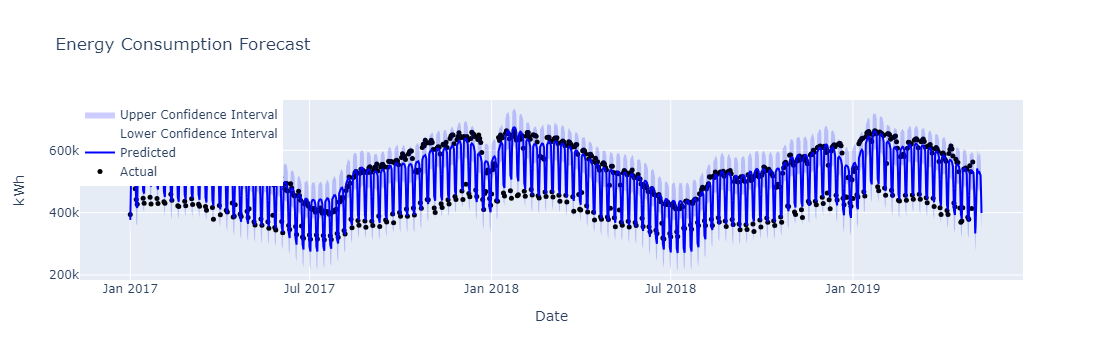

In [27]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Combine the 'ds' columns from train_df and val_df
combined_dates = pd.concat([train_df['ds'], val_df['ds']])

# Create traces for the forecast
trace_predicted = go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat'], 
    mode='lines', 
    name='Predicted',
    line=dict(color='blue')
)

trace_actual = go.Scatter(
    x=combined_dates,
    y=model_default.history['y'],           # Historical data values
    mode='markers',                          # Use markers for actual data points
    name='Actual',
    marker=dict(color='black', size=5)
)

trace_upper = go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat_upper'], 
    mode='lines', 
    name='Upper Confidence Interval',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(0, 0, 255, 0.2)'
)

trace_lower = go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat_lower'], 
    mode='lines', 
    name='Lower Confidence Interval',
    line=dict(width=0)
)

# Create figure
fig = make_subplots()

# Add traces
fig.add_trace(trace_actual)
fig.add_trace(trace_predicted)
fig.add_trace(trace_lower)
fig.add_trace(trace_upper)

# Update layout
fig.update_layout(
    title='Energy Consumption Forecast',
    xaxis_title='Date',
    yaxis_title='kWh',
    legend=dict(x=0, y=1)
)

# Show plot
fig.show()


As we can see, the fit is not satisfactory as the model underestimates and overestimates the data at regular intervals (the blue line is consistently lower and higher than the black "curve" (dots), even if the 95% intervals cover the black dots.

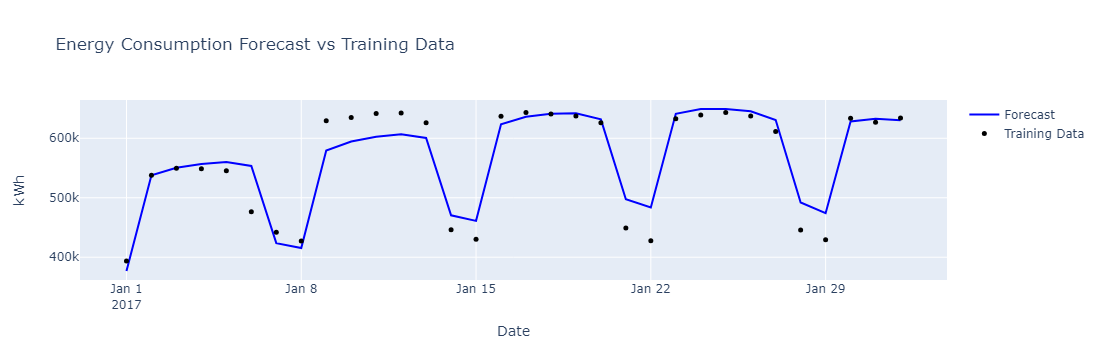

In [34]:
import plotly.graph_objs as go

# Filter the forecast and training data for the specified time period
forecast_period = forecast[(forecast['ds'] >= '2017-01-01') & (forecast['ds'] <= '2017-02-01')]
train_period = train_df[(train_df['ds'] >= '2017-01-01') & (train_df['ds'] <= '2017-02-01')]

# Create traces for the forecast and training data
trace_forecast = go.Scatter(
    x=forecast_period['ds'], 
    y=forecast_period['yhat'], 
    mode='lines', 
    name='Forecast',
    line=dict(color='blue')
)

trace_train = go.Scatter(
    x=train_period['ds'],
    y=train_period['y'],
    mode='markers',
    name='Training Data',
    marker=dict(color='black', size=5)
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace_forecast)
fig.add_trace(trace_train)

# Update layout
fig.update_layout(
    title='Energy Consumption Forecast vs Training Data',
    xaxis_title='Date',
    yaxis_title='kWh'
)

# Show plot
fig.show()


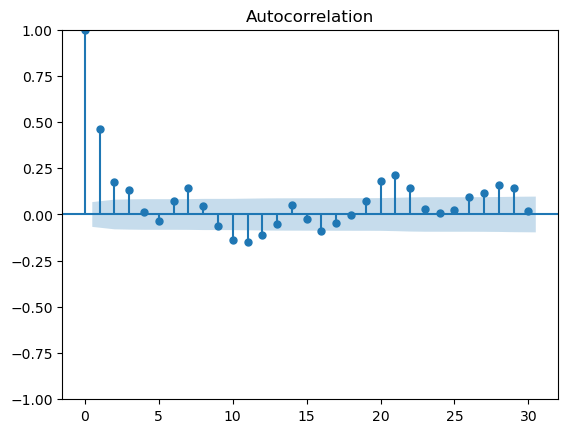

In [39]:
acf_res(forecast, train_df)

In a satisfactory model, the autocorrelations should be very low (they should lie within the blue 95% confidence band). However, in the plot above, not only are the autocorrelations high, they also lie outside the band.

From all plots above, we can conclude that the model regularly underestimates as well as overestimates the data, and that the model is not satisfactory.

Next, we plot some components of the models: the trend and the seasonalities.

C:\Users\Administrator\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Administrator\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Administrator\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



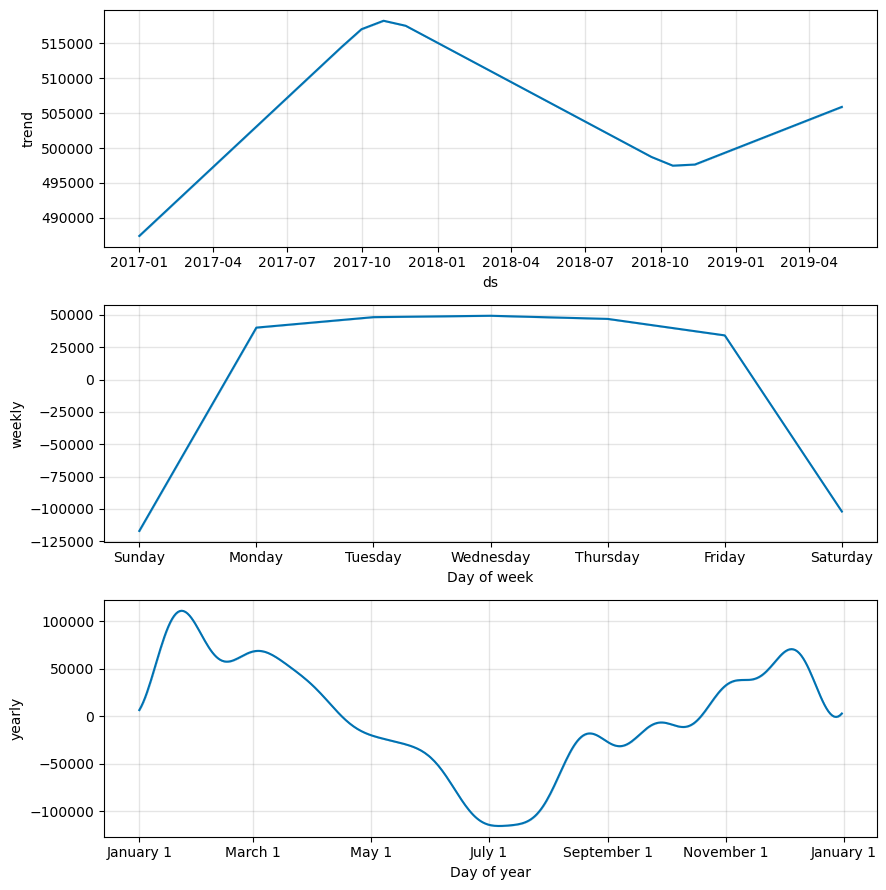

In [43]:
fig2 = model_default.plot_components(forecast)

Remarks: the default model correctly identifies that during a day, the electricity demand typically reaches its daily peak around noon (the time zone of the data is in UTC, but the origin of the data is in UTC+2 or UTC+3 time zone). It also correctly identifies that in a year, the demand typically reaches its lowest in the summer. In contrast, the demand is typically very high in the winter. In addition, in a week, the model correctly identifies that the demand is lower in weekends and higher in weekdays.

### Custom Prophet model

#### Fitting the model

After a careful look at the data, we observe that in the summer, the within-day variation in electricity demand seems to be smaller than that in the winter. This suggests that this variation has a multiplicative effect. In addition, we notice that the demand is always lower in the weekend than during the weekdays. In addition, within each year, we see that there is a decreasing trend in the first half of the year and an increasing trend in the second half of the year.

In light of the observations above, we add our custom seasonalities. First of all, we add seasonalities for weekends and weekdays for each season (winter, spring, summer, autumn). However, we transform the data by logarithmizing the values because we wish the seasonalities to have a multiplicative effect on each other as log of a product is a sum:

$$
\begin{aligned}
y_t&=g(t)\times s(t)\times h(t)\\
\Rightarrow \log{y_t}&=\log{g(t)}+\log{s(t)}+\log{h(t)}
\end{aligned}
$$

In [45]:
train_df, val_df, test_df = train_val_test_split(to_log(df, ['y']))
train_df = add_custom_seasonality(train_df)
val_df = add_custom_seasonality(val_df)
test_df = add_custom_seasonality(test_df)
future = add_custom_seasonality(future)

In [47]:
a = pd.date_range(start='2017-01-01', end='2017-01-08', freq='1D').to_series()
b = pd.date_range(start='2017-12-20', end='2018-01-08', freq='1D').to_series()
c = pd.date_range(start='2018-12-20', end='2019-01-08', freq='1D').to_series()
d = pd.date_range(start='2019-12-20', end='2020-01-01', freq='1D').to_series()

# In Finland, usually Christmas and New year holidays last acoording to the date ranges above
christmas_newyear = pd.DataFrame({
    'holiday': 'christmas_newyear',
    'ds': pd.concat([a, b, c, d], axis=0).values
})

In [49]:
def better_prophet():
    model_improved = Prophet(
        changepoint_prior_scale=0.5,
        daily_seasonality=False,
        holidays = christmas_newyear,
        interval_width=0.95)

    # The higher the fourier_order, the more wiggly the seasonality component becomes
    model_improved.add_seasonality(name='spring_weekday', period=1, fourier_order=12, condition_name='spring_weekday')
    model_improved.add_seasonality(name='spring_weekend', period=1, fourier_order=12, condition_name='spring_weekend')
    model_improved.add_seasonality(name='summer_weekday', period=1, fourier_order=12, condition_name='summer_weekday')
    model_improved.add_seasonality(name='summer_weekend', period=1, fourier_order=12, condition_name='summer_weekend')
    model_improved.add_seasonality(name='autumn_weekday', period=1, fourier_order=12, condition_name='autumn_weekday')
    model_improved.add_seasonality(name='autumn_weekend', period=1, fourier_order=12, condition_name='autumn_weekend')
    model_improved.add_seasonality(name='winter_weekday', period=1, fourier_order=12, condition_name='winter_weekday')
    model_improved.add_seasonality(name='winter_weekend', period=1, fourier_order=12, condition_name='winter_weekend')
    model_improved.add_country_holidays(country_name='Finland')
    return model_improved

In [50]:
model_improved = better_prophet()
model_improved.fit(train_df)

11:00:34 - cmdstanpy - INFO - Chain [1] start processing
11:00:43 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Administrator\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



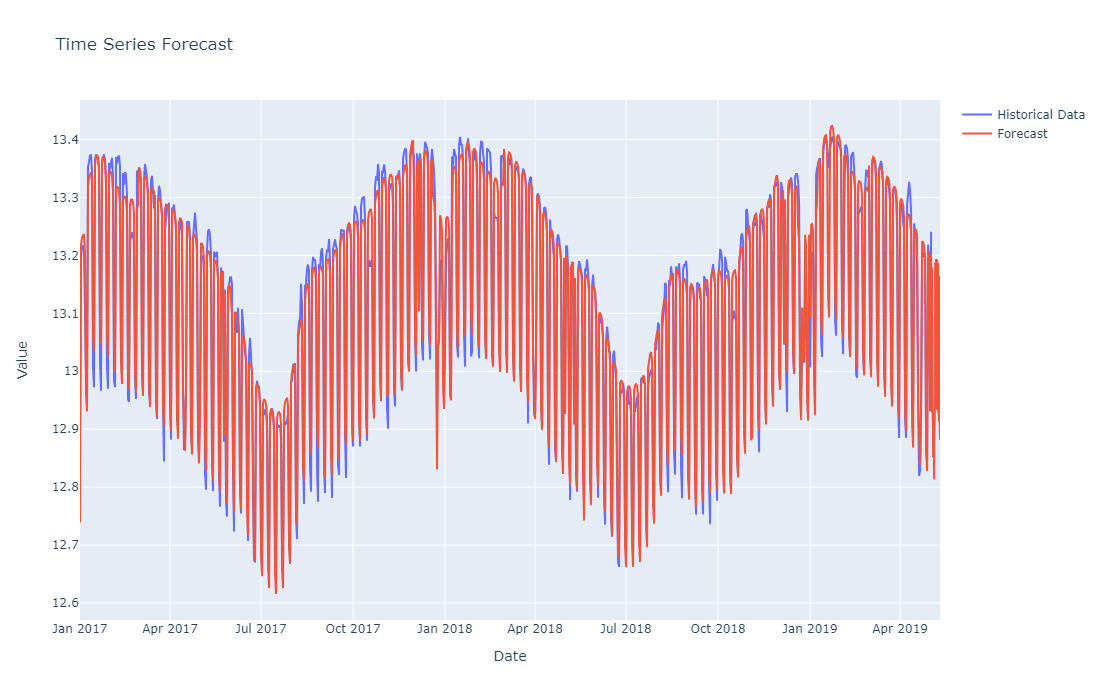

In [54]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming forecast_improved is the output from model_improved.predict(future)
# and model_improved is your trained Prophet model

# Extract historical data from the model's training data
historical_data = model_improved.history
historical_dates = historical_data['ds']
historical_values = historical_data['y']

# Extract forecasted data
forecast_dates = forecast_improved['ds']
forecast_values = forecast_improved['yhat']

# Create a Plotly figure
fig = go.Figure()

# Add historical data to the plot
fig.add_trace(go.Scatter(x=historical_dates, y=historical_values, mode='lines', name='Historical Data'))

# Add forecasted data to the plot
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values, mode='lines', name='Forecast'))

# Customize the layout
fig.update_layout(
    title='Time Series Forecast',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1500,
    height=700
)

# Show the plot
fig.show()


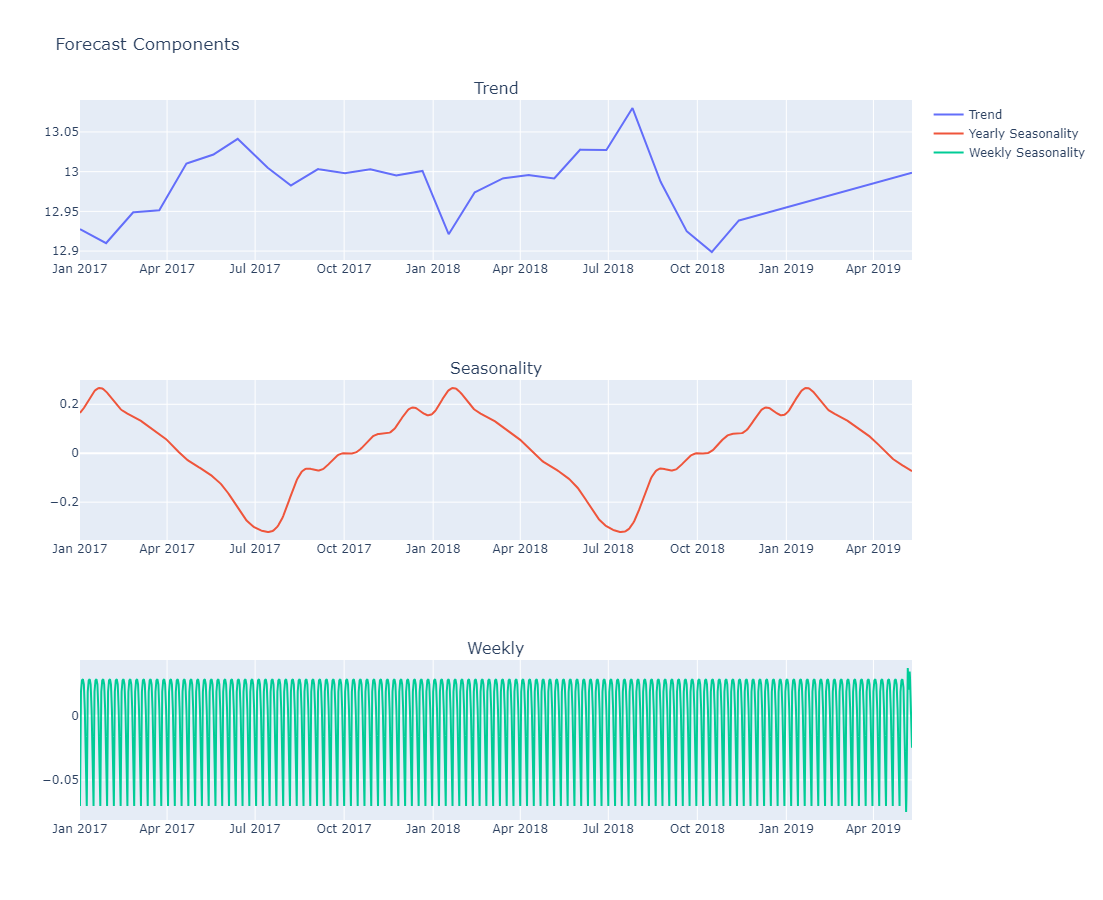

In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming forecast_improved is the output from model_improved.predict(future)
# and model_improved is your trained Prophet model

# Extract the components from forecast_improved
trend = forecast_improved['trend']
seasonal = forecast_improved['yearly'] if 'yearly' in forecast_improved else None
weekly = forecast_improved['weekly'] if 'weekly' in forecast_improved else None
daily = forecast_improved['daily'] if 'daily' in forecast_improved else None

# Create subplots: 1 row for each component
rows = 1 + (1 if seasonal is not None else 0) + (1 if weekly is not None else 0) + (1 if daily is not None else 0)
fig = make_subplots(rows=rows, cols=1, subplot_titles=["Trend", "Seasonality", "Weekly", "Daily"])

# Plot trend
fig.add_trace(go.Scatter(x=forecast_improved['ds'], y=trend, mode='lines', name='Trend'), row=1, col=1)

current_row = 2

# Plot yearly seasonality if available
if seasonal is not None:
    fig.add_trace(go.Scatter(x=forecast_improved['ds'], y=seasonal, mode='lines', name='Yearly Seasonality'), row=current_row, col=1)
    current_row += 1

# Plot weekly seasonality if available
if weekly is not None:
    fig.add_trace(go.Scatter(x=forecast_improved['ds'], y=weekly, mode='lines', name='Weekly Seasonality'), row=current_row, col=1)
    current_row += 1

# Plot daily seasonality if available
if daily is not None:
    fig.add_trace(go.Scatter(x=forecast_improved['ds'], y=daily, mode='lines', name='Daily Seasonality'), row=current_row, col=1)

# Update layout
fig.update_layout(
    title='Forecast Components',
    height=300 * rows,  # Adjust height based on the number of components
)

# Show the plot
fig.show()


C:\Users\Administrator\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



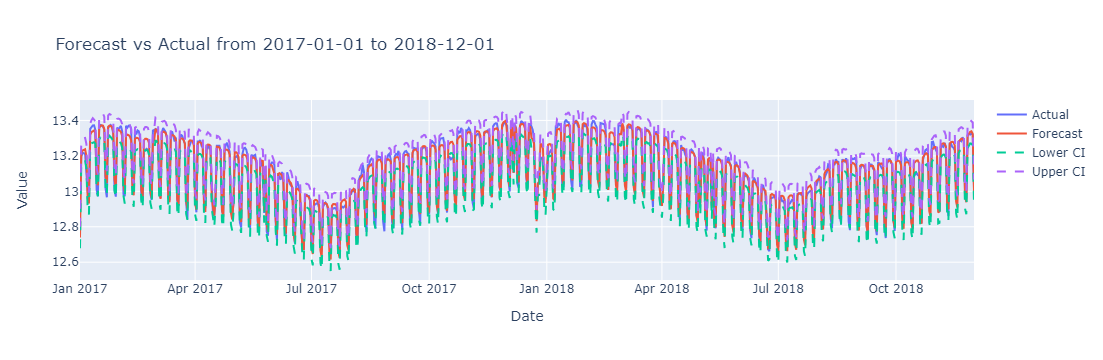

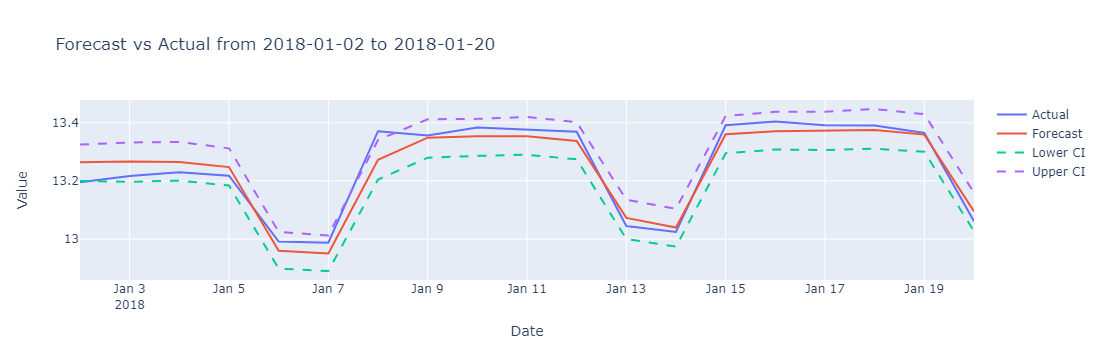

In [58]:
import plotly.graph_objects as go
import pandas as pd

# Function to transform the data (assuming this is how your to_exp function works)
def to_exp(df, columns):
    return df[['ds'] + columns]

# Create Plotly plot for a given time range
def plot_forecast(forecast_df, train_df, start_date, end_date):
    # Filter data for the specified date range
    forecast_filtered = forecast_df[(forecast_df['ds'] >= start_date) & (forecast_df['ds'] <= end_date)]
    train_filtered = train_df[(train_df['ds'] >= start_date) & (train_df['ds'] <= end_date)]

    # Create the plot
    fig = go.Figure()

    # Add training data
    fig.add_trace(go.Scatter(x=train_filtered['ds'], y=train_filtered['y'], mode='lines', name='Actual'))

    # Add forecasted data
    fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_lower'], mode='lines', name='Lower CI', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_upper'], mode='lines', name='Upper CI', line=dict(dash='dash')))

    # Customize layout
    fig.update_layout(
        title=f'Forecast vs Actual from {start_date} to {end_date}',
        xaxis_title='Date',
        yaxis_title='Value'
    )

    # Show the plot
    fig.show()

# Transform the data
forecast_improved_exp = to_exp(forecast_improved, ['yhat', 'yhat_lower', 'yhat_upper'])
train_df_exp = to_exp(train_df, ['y'])

# Plot for the given date ranges
plot_forecast(forecast_improved_exp, train_df_exp, '2017-01-01', '2018-12-01')
plot_forecast(forecast_improved_exp, train_df_exp, '2018-01-02', '2018-01-20')


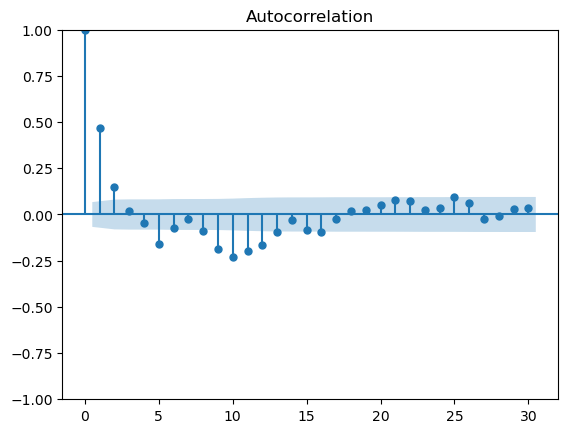

In [60]:
acf_res(forecast_improved, train_df)

Although the model consistently overpredicts in the summer, the forecasts are quite satisfactory in other seasons. Judging from the last plot above, the residual autocorrelations are much lower than those of the previous model.

### Cross-validation

Cross-validation on time series data is different from that on common non time-series data because there is a time structure which must not be broken with random partitioning used in normal cross-validation methods. This is why Prophet has its own cross-validation methods.

The cross-validation procedure is as follows. First, the model is trained on the first 8766 hours of the data (initial). Then, it forecasts the next 720 hours of data (horizon). After that, the model is trained on the first 8766 hours plus the next 1440 hours (period by default) and make predictions on the next 720 hours after that 360 hours. This procedure continues (training data has 1440-hour increments and forecasts are made on the next 720 hours) until there is not enough data left to do this.

In [64]:
df_cv = cross_validation(model_improved, initial='370 days', period='30 days', horizon='15 days', parallel="processes")

In [65]:
df_p = performance_metrics(df_cv)
df_p

horizon       mse      rmse       mae      mape     mdape     smape  \
0   2 days  0.004131  0.064275  0.042026  0.003195  0.001972  0.003202   
1   3 days  0.006791  0.082410  0.056778  0.004314  0.003934  0.004326   
2   4 days  0.004869  0.069781  0.050893  0.003879  0.002972  0.003887   
3   5 days  0.004547  0.067432  0.052669  0.004010  0.003307  0.004017   
4   6 days  0.006928  0.083233  0.063781  0.004858  0.003097  0.004862   
5   7 days  0.006959  0.083422  0.059648  0.004538  0.002741  0.004550   
6   8 days  0.005996  0.077432  0.052649  0.004005  0.003085  0.004019   
7   9 days  0.009335  0.096620  0.066887  0.005099  0.003692  0.005119   
8  10 days  0.012743  0.112884  0.082652  0.006301  0.004425  0.006327   
9  11 days  0.014472  0.120299  0.087384  0.006661  0.003657  0.006692   
10 12 days  0.014513  0.120471  0.089410  0.006796  0.004472  0.006827   
11 13 days  0.015918  0.126165  0.094789  0.007214  0.005251  0.007245   
12 14 days  0.017514  0.132339  0.097862  0.007462  0.005229  0.007494   
13 15 days  0.021233  0.145716  0.103006  0.007846  0.004437  0.007889   

    coverage  
0   0.750000  
1   0.604167  
2   0.645833  
3   0.687500  
4   0.687500  
5   0.687500  
6   0.812500  
7   0.666667  
8   0.604167  
9   0.583333  
10  0.562500  
11  0.479167  
12  0.520833  
13  0.645833

C:\Users\Administrator\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



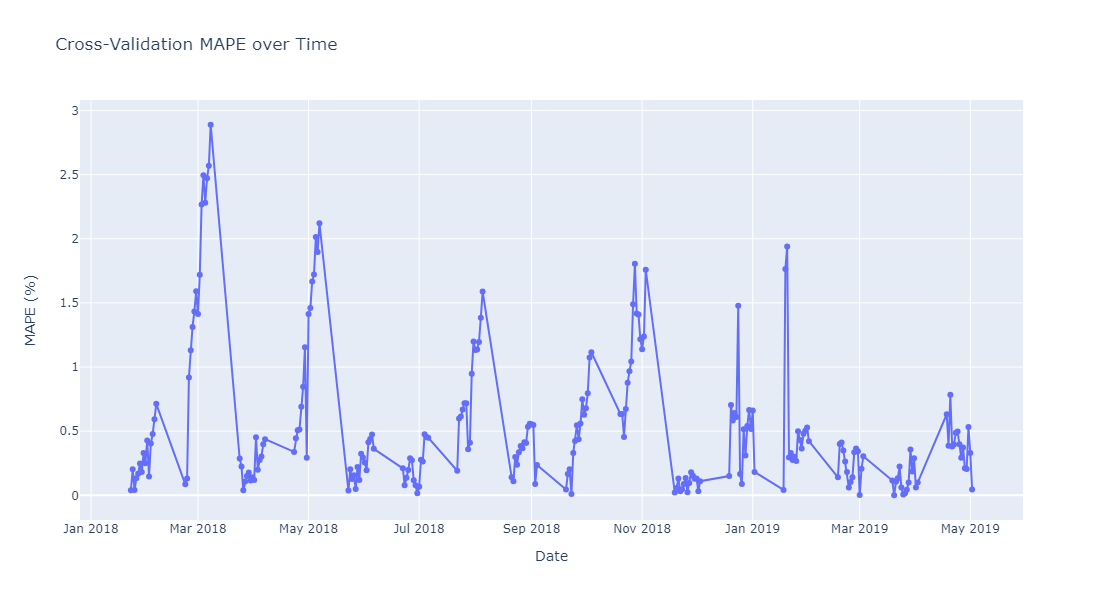

In [66]:
import plotly.graph_objects as go
import pandas as pd

# Assuming df_cv is your DataFrame with cross-validation results

# Compute MAPE
df_cv['mape'] = (abs(df_cv['y'] - df_cv['yhat']) / df_cv['y']) * 100

# Aggregate MAPE by horizon (or any other relevant column if needed)
df_mape = df_cv.groupby('ds').agg({'mape': 'mean'}).reset_index()

# Create Plotly figure
fig_cv = go.Figure()

# Add MAPE over time
fig_cv.add_trace(go.Scatter(x=df_mape['ds'], y=df_mape['mape'], mode='lines+markers', name='MAPE'))

# Customize layout
fig_cv.update_layout(
    title='Cross-Validation MAPE over Time',
    xaxis_title='Date',
    yaxis_title='MAPE (%)',
    height=600,
    width=1000
)

# Show the plot
fig_cv.show()


It seems that this model is good enough.

## Model selection

We could finally evaluate the better model's performance on the test set by retraining it on the aggregation of the train set and the validation set.

In [67]:
train, test = train_val_test_split(to_log(add_custom_seasonality(df.reset_index()), ['y']).set_index('ds'), validation=False)
model_final = better_prophet()
model_final.fit(train)

11:17:58 - cmdstanpy - INFO - Chain [1] start processing
11:18:16 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
future = model_final.make_future_dataframe(periods=len(test), freq='H')
future = add_custom_seasonality(future)
forecast = model_final.predict(future)

C:\Users\Administrator\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



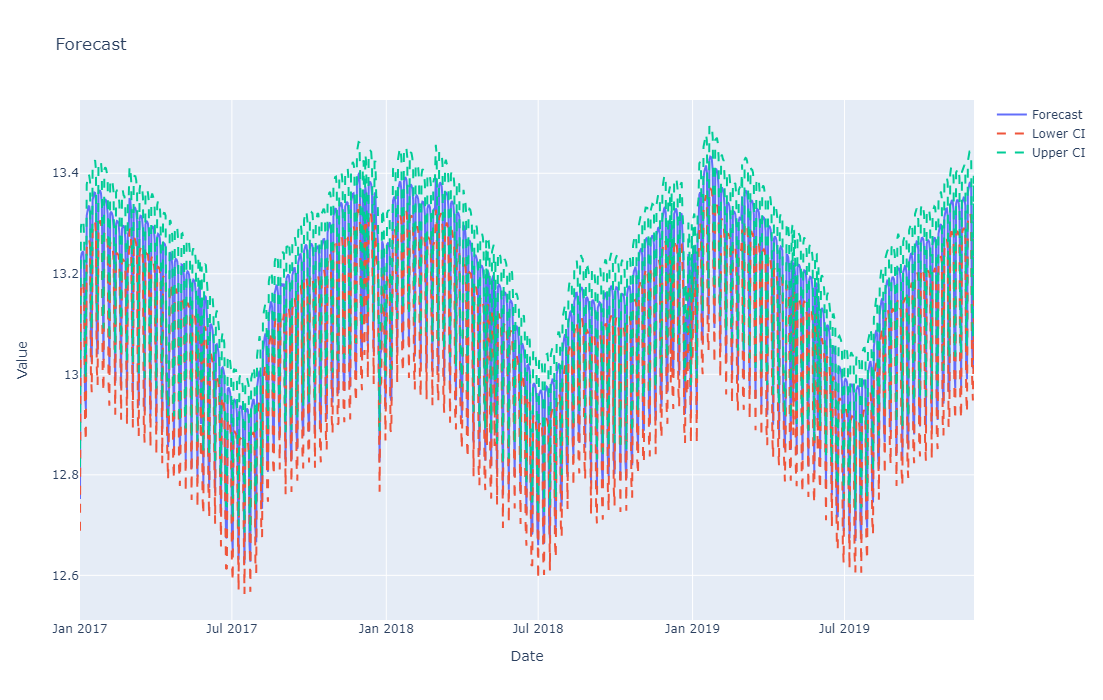

In [69]:
import plotly.graph_objects as go

# Assuming future, forecast, and model_final are already defined

# Create a Plotly figure
fig = go.Figure()

# Add actual data if available
if 'y' in future:
    fig.add_trace(go.Scatter(x=future['ds'], y=future['y'], mode='lines', name='Actual'))

# Add forecasted values
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Lower CI', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Upper CI', line=dict(dash='dash')))

# Add custom seasonality if available
# (Replace 'custom_seasonality' with your custom seasonality column name if different)
if 'custom_seasonality' in forecast:
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['custom_seasonality'], mode='lines', name='Custom Seasonality'))

# Customize layout
fig.update_layout(
    title='Forecast',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1500,
    height=700
)

# Show the plot
fig.show()


Note that for Prophet models, the wider the blue bands (relative to the predictions), the more likely the model is overfit. Here, we see that this is not the case. Now, we evaluate the model on the test set:

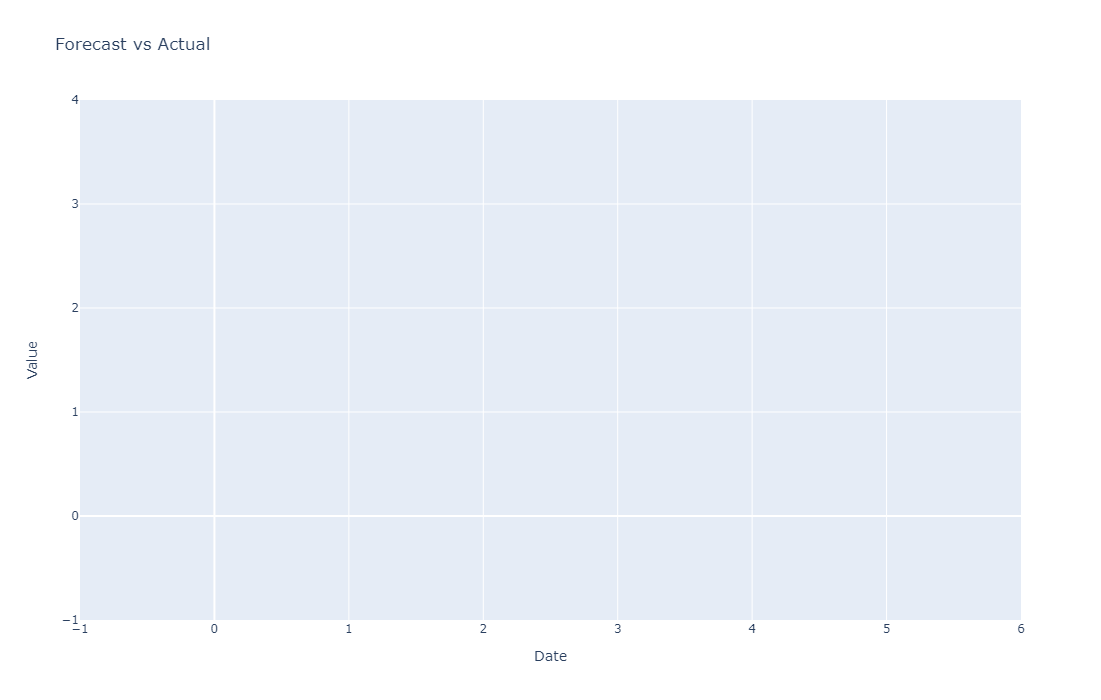

In [71]:
import plotly.graph_objects as go

# Assuming to_exp() function converts the data appropriately

# Define the start and end dates for the plot
start_date = '2020-02-01'
end_date = '2020-04-01'

# Filter forecast and test data for the specified date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
test_filtered = test[(test['ds'] >= start_date) & (test['ds'] <= end_date)]

# Create a Plotly figure
fig = go.Figure()

# Add traces for the forecasted values and the actual test data
# Plot forecasted values
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_lower'], mode='lines', name='Lower CI', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_upper'], mode='lines', name='Upper CI', line=dict(dash='dash')))

# Plot actual test data
fig.add_trace(go.Scatter(x=test_filtered['ds'], y=test_filtered['y'], mode='lines', name='Actual'))

# Customize layout
fig.update_layout(
    title='Forecast vs Actual',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1500,
    height=700
)

# Show the plot
fig.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9548\1892693269.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



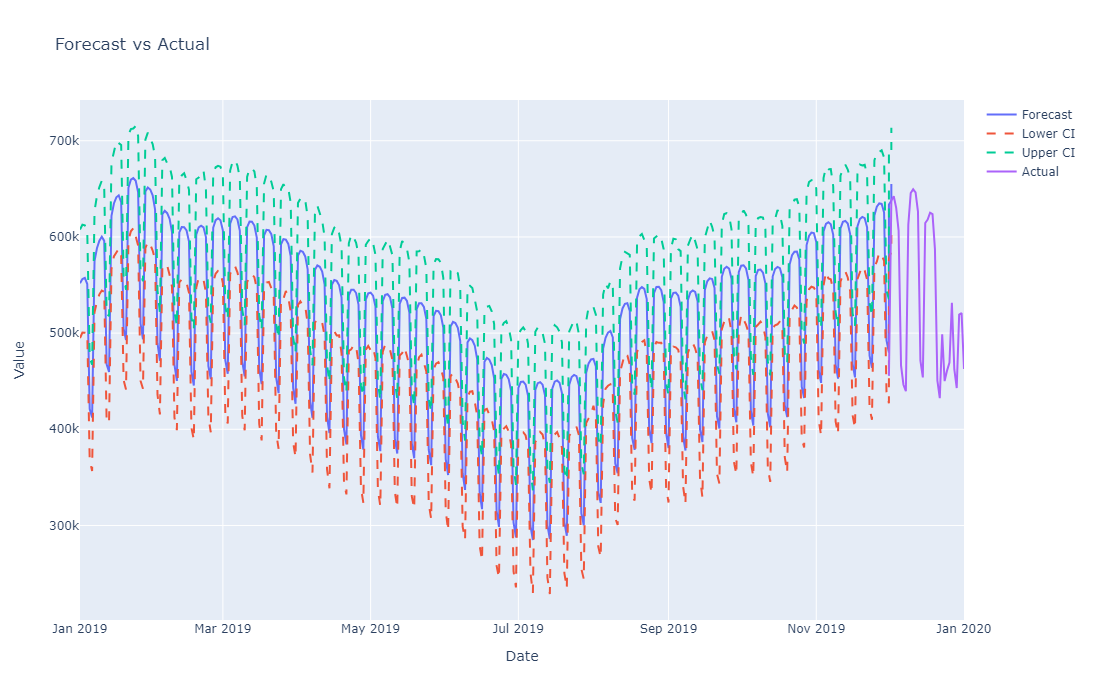

In [94]:
import plotly.graph_objects as go
import pandas as pd

# Convert time units from hours to days
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date
test['ds'] = pd.to_datetime(test['ds']).dt.date

# Define the start and end dates for the plot as datetime.date objects
start_date = pd.to_datetime('2019-01-01').date()
end_date = pd.to_datetime('2020-01-01').date()

# Filter forecast and test data for the specified date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
test_filtered = test[(test['ds'] >= start_date) & (test['ds'] <= end_date)]

# Create a Plotly figure
fig = go.Figure()

# Add traces for the forecasted values and the actual test data
# Plot forecasted values
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_lower'], mode='lines', name='Lower CI', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=forecast_filtered['ds'], y=forecast_filtered['yhat_upper'], mode='lines', name='Upper CI', line=dict(dash='dash')))

# Plot actual test data
fig.add_trace(go.Scatter(x=test_filtered['ds'], y=test_filtered['y'], mode='lines', name='Actual'))

# Customize layout
fig.update_layout(
    title='Forecast vs Actual',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1500,
    height=700
)

# Show the plot
fig.show()


In [87]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Convert time units from hours to days
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date
test['ds'] = pd.to_datetime(test['ds']).dt.date

# Define the start and end dates for the evaluation as datetime.date objects
start_date = pd.to_datetime('2019-12-01').date()
end_date = pd.to_datetime('2020-01-01').date()

# Filter forecast and test data for the specified date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
test_filtered = test[(test['ds'] >= start_date) & (test['ds'] <= end_date)]

# Extract true and predicted values for the specified date range
y_true = to_exp(test_filtered, ['y'])['y']
y_pred = to_exp(forecast_filtered, ['yhat']).set_index('ds').loc[start_date:end_date].reset_index()['yhat']

# Truncate y_pred to match the length of y_true
y_pred_truncated = y_pred[:len(y_true)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred_truncated))

# Calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_val = mape(y_true, y_pred_truncated)

print(f"The RMSE of the better model is: {rmse:.2f}")
print(f"The MAPE of the better model is: {mape_val:.2f}")


The RMSE of the better model is: 0.20
The MAPE of the better model is: 1.23


In [88]:
train, test = train_val_test_split(df, validation=False)
m = Prophet(interval_width=0.95)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)

11:42:20 - cmdstanpy - INFO - Chain [1] start processing
11:42:20 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have already defined the 'forecast' and 'test' DataFrames

# Convert time units from hours to days
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.date
test['ds'] = pd.to_datetime(test['ds']).dt.date

# Define the start and end dates for the evaluation as datetime.date objects
start_date = pd.to_datetime('2019-12-01').date()
end_date = pd.to_datetime('2020-01-01').date()

# Filter forecast and test data for the specified date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].copy()
test_filtered = test[(test['ds'] >= start_date) & (test['ds'] <= end_date)].copy()

# Convert 'ds' column to datetime.date after filtering
forecast_filtered['ds'] = pd.to_datetime(forecast_filtered['ds'])
test_filtered['ds'] = pd.to_datetime(test_filtered['ds'])

# Merge forecast and test data on 'ds' column
merged_data = pd.merge(test_filtered, forecast_filtered, on='ds', how='inner')

# Extract y_true and y_pred2 values
y_true = merged_data['y']
y_pred2 = merged_data['yhat']

# Calculate RMSE
rmse2 = np.sqrt(mean_squared_error(y_true, y_pred2))

# Calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_val2 = mape(y_true, y_pred2)

print(f"The RMSE of the default model is: {rmse2:.2f}")
print(f"The MAPE of the default model is: {mape_val2:.2f}")


The RMSE of the default model is: 98918.09
The MAPE of the default model is: 17.22


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9548\800401711.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The MAPE of the better model is half that of the default model. The RMSE is also much lower. We successfully improved on the default model.

The purpose of the validation set was to help tune the hyperparameters of the Prophet models. This is not of great importance to this project, but we could try doing it in the future.